# 📈 Inference Pipeline (No GROBID)

This notebook:
- Loads your trained classifier (`saved_model`)
- Reads PDFs directly via Marker-PDF
- Predicts `type`
- Extracts `dataset_id` using regex
- Produces `submission.csv`

**Note:** No GROBID needed.

In [1]:
SUBMIT = True

In [ ]:
import os
! mkdir cache data
os.environ["XDG_CACHE_HOME"] = os.path.join(os.getcwd(), "cache")
os.environ["XDG_DATA_HOME"] = os.path.join(os.getcwd(), "data")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
! cp -r /kaggle/input/datalab-marker/kaggle/working/datalab ./cache
! cp -r /kaggle/input/pip-datalab/kaggle/working/cache/pip ./cache
! mkdir -p /usr/local/lib/python3.11/dist-packages/static/fonts
! cp /kaggle/input/marker-font/GoNotoCurrent-Regular.ttf /usr/local/lib/python3.11/dist-packages/static/fonts/GoNotoCurrent-Regular.ttf
! pip install /kaggle/working/cache/pip/wheels/8d/ac/a9/4e6dd2d86235ea3da1c286279118c49e931f77cfb33e9b1af5/EbookLib-0.18-py3-none-any.whl
! sh /kaggle/input/mdc-marker-pdf-reqs/install_requirements.sh

In [3]:
# 📚 Imports
import re
import pandas as pd
from glob import glob
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from pathlib import Path

from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered

2025-07-08 09:32:43.705027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751967163.888073      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751967163.940499      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# 🧠 Load model and tokenizer
model_path = "/kaggle/input/makedatacount-mixed-train/saved_model_dual_text"
token_path = model_path

tokenizer = AutoTokenizer.from_pretrained(token_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
# 🧩 Utility functions
REPO_KEYWORDS = ['zenodo', 'dryad', 'figshare', 'pangaea', 'tcia']

def standardize_doi(doi):
    doi = str(doi).strip()
    if doi.startswith("http"):
        return doi #.lower()
    if doi.startswith("doi:"):
        return "https://doi.org/" + doi[4:] #.lower()
    if doi.startswith("10."):
        return "https://doi.org/" + doi #.lower()
    return doi #.lower()

def extract_dataset_dois(text):
    text = text.replace('](', '] (').replace(')](', ') (')
    url_pattern = r'https?://[^\s\)<>\]]+'
    urls = re.findall(url_pattern, text)
    doi_pattern = r'\b10\.\d{4,9}/[^\s\)<>\]]+'
    bare_dois = re.findall(doi_pattern, text)

    candidates = []
    for u in urls:
        if 'doi.org/10.' in u:
            candidates.append(u.rstrip('.,;)]>'))
    for d in bare_dois:
        candidates.append(standardize_doi(d))

    return sorted(set(candidates))

def find_accession_ids_in_text(text):
    patterns = [
        r'\b(GSE\d+)\b',
        r'\b(PRJ[ENAD]\d+)\b',
        r'\b(SRP\d+)\b',
        r'\b(E-[A-Z]+-\d+)\b',
        r'\b(pdb\s[\d\w]+)\b',
        r'\b(CHEMBL\d+)\b'
    ]
    matches = []
    for pat in patterns:
        matches.extend(re.findall(pat, text, re.IGNORECASE))
    return [m.replace(" ", "") for m in matches] #[m.lower().replace(" ", "") for m in matches]

In [6]:
all_accession_patterns=['(GSE\\d+)',
 '(PRJ[ENAD]\\d+)',
 '(SRP\\d+)',
 '(E\\-[A-Z]+\\-\\d+)',
 '(CHEMBL\\d+)',
 '([A-Z0-9]{4})',
 '(BX\\d+)',
 '(CAB\\d+)',
 '(CP\\d+)',
 '(CVCL\\d+)',
 '(D\\d+)',
 '(EMPIAR\\d+)',
 '(ENSBTAG\\d+)',
 '(ENSMMUT\\d+)',
 '(ENSOARG\\d+)',
 '(EPI\\d+)',
 '(ERR\\d+)',
 '(F\\d+)',
 '(HPA\\d+)',
 '(IPR\\d+)',
 '(K\\d+)',
 '(KX\\d+)',
 '(MODEL\\d+)',
 '(NC\\d+)',
 '(NM\\d+)',
 '(O\\d+)',
 '(P\\d+)',
 '(PF\\d+)',
 '(PRJNA\\d+)',
 '(PXD\\d+)',
 '(Q\\d+)',
 '(SAMN\\d+)',
 '(SRR\\d+)',
 '(SRX\\d+)',
 '(STH\\d+)']

# DOI extractor
def extract_dois(text):
    # Regex for DOI-like URLs
    doi_pattern = r'https?://doi\.org/10\.\d{4,9}/[^\s\)\]\}\.,;]+'
    matches = re.findall(doi_pattern, text)
    # Deduplicate & clean
    return sorted(set(m.rstrip('.;,)]>') for m in matches))

# Accession extractor
def extract_accessions(text):
    found = []
    for pat in all_accession_patterns:
        found.extend(re.findall(pat, text, re.IGNORECASE))
    return sorted(set(f for f in found))

In [7]:
import re

def extract_dataset_ids(text):
    """
    Extract DOIs and known accession IDs robustly.
    Returns a sorted list of unique dataset IDs.
    """
    repos = ['dryad','zenodo','figshare','pangaea','tcia','p9','d9','pasta','cranfield','dtu','usn','f7','jb','xyb','dl']
    candidates = set()

    # DOI pattern (strict)
    doi_pattern = r'10\.\d{4,9}/[^\s\)\]<]+'
    for match in re.findall(doi_pattern, text):
        clean = match.rstrip('.,;)]>').strip()
        # Keep only known repositories
        if any(repo in clean.lower() for repo in repos):
            candidates.add(f"https://doi.org/{clean}")

    # Accession patterns
    accession_patterns = [
        r'\b(GSE\d+)\b',
        r'\b(PRJ[EDNA]\d+)\b',
        r'\b(SRP\d+)\b',
        r'\b(E-[A-Z]+-\d+)\b',
        r'\b(pdb\s*\w+)\b',
        r'\b(CHEMBL\d+)\b',
        r'\b(EMPIAR\d+)\b',
        r'\b(ENSM\d+)\b',
        r'\b(PXD\d+)\b',
        r'\b(SAMN\d+)\b',
        r'\b(SRR\d+)\b',
        r'\b(SRX\d+)\b',
        r'\b(IPR\d+)\b',
        r'\b(SVA\d+)\b',
        r'\b(NC_\d+\.\d+)\b',
        r'\b(NM_\d+)\b',
        r'\b(PF\d+)\b',
        r'\b(K\d+)\b',
        r'\b(Q\d+)\b',
        r'\b(O\d+)\b',
        r'\b(MODEL\d+)\b',
        r'\b(rs\d+)\b',
    ]
    for pat in accession_patterns:
        candidates.update(re.findall(pat, text))

    # Filter: drop very short garbage
    candidates = [c for c in candidates if len(c) >= 5]

    return sorted(candidates)

In [8]:
# REGEX
re_doi = re.compile(r"10\.\d{4}")
big_re = re.compile(r"GSE\d+|SR[APRX]\d+|PRJ[NAED][A-Z]?\d+|IPR\d{6}|PF\d{5}|EMPIAR-\d{5}|CHEMBL\d+|CVCL_[A-Z0-9]{4}|ENS[A-Z]{0,6}[GT]\d{11}|N[MC]_\d+(?:\.\d+)?|rs\d+|EPI(?:_ISL_)?\d+|PXD\d{6}|SAM[ND]\d+|ERR\d+", re.I)

# REMOVE REFERENCES
def remove_references_section(text):
    lines = text.split('\n')
    cut_index = -1
    for i in range(len(lines) - 1, max(0, int(len(lines) * 0.3)), -1):
        line = lines[i].strip()
        patterns = [r'^REFERENCES?$', r'^\d+\.?\s+REFERENCES?$', r'^\d+\.?\s+References?$', r'^References?:$',
                    r'^BIBLIOGRAPHY$', r'^\d+\.?\s+BIBLIOGRAPHY$', r'^\d+\.?\s+Bibliography$', r'^Bibliography:$',
                    r'^Literature\s+Cited$', r'^Works\s+Cited$']
        if any(re.match(p, line, re.I) for p in patterns):
            following = lines[i+1:i+4]
            if any(re.search(r'\(\d{4}\)|\d{4}\.|doi:| et al', fl, re.I) for fl in following):
                cut_index = i
                break
    return '\n'.join(lines[:cut_index]).strip() if cut_index != -1 else text.strip()

In [9]:
def extract_article_id(filename):
    # return filename[:-4].replace("_", "/")
    return Path(pdf_path).stem

In [10]:
os.environ["DETECTOR_MODEL_CHECKPOINT"] = "/kaggle/working/cache/datalab/modelstext_detection/2025_05_07"
os.environ["RECOGNITION_MODEL_CHECKPOINT"] = "/kaggle/working/cache/datalab/modelstext_recognition/2025_05_16"
os.environ["LAYOUT_MODEL_CHECKPOINT"] = "/kaggle/working/cache/datalab/modelslayout/2025_02_18"
os.environ["OCR_ERROR_MODEL_CHECKPOINT"] = "/kaggle/working/cache/datalab/modelsocr_error_detection/2025_02_18"
os.environ["TABLE_REC_MODEL_CHECKPOINT"] = "/kaggle/working/cache/datalab/modelstable_recognition/2025_02_18"

In [11]:
# Collect PDF files
# pdf_files = sorted(glob(os.path.join(pdf_dir, "*.pdf")))

# Collect XML basenames for lookup
import os
if SUBMIT:
    pdf_dir = "/kaggle/input/make-data-count-finding-data-references/test/PDF"
    xml_dir = "/kaggle/input/make-data-count-finding-data-references/test/XML"
else: # infer on train_labels
    pdf_dir = "/kaggle/input/make-data-count-finding-data-references/train/PDF"
    xml_dir = "/kaggle/input/make-data-count-finding-data-references/train/XML"
pdf_files = [os.path.join(pdf_dir, f) for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
# xml_basenames = [os.path.join(xml_dir, f) for f in os.listdir(xml_dir) if f.endswith(".xml")]
xml_basenames = set(
    os.path.splitext(os.path.basename(p))[0]
    for p in glob(os.path.join(xml_dir, "*.xml"))
)

# pdf_files = sorted(glob(os.path.join(pdf_dir, "*.pdf")))
converter = PdfConverter(artifact_dict=create_model_dict(device='cuda'))

rows = []
def extract_text_from_pdf(file_path):
    rendered = converter(file_path)
    text, _, _ = text_from_rendered(rendered)
    text = remove_references_section(text)
    return text

import xml.etree.ElementTree as ET

tree = ET.parse("/kaggle/input/make-data-count-finding-data-references/test/XML/10.1002_2017jc013030.xml")
root = tree.getroot()
ns = {"tei": "http://www.tei-c.org/ns/1.0"}

tei_elem = root.find(".//tei:tei", namespaces=ns)
print("tei_elem:", tei_elem)

if tei_elem is not None:
    body = tei_elem.find(".//tei:body", namespaces=ns)
    print("body:", body)


import xml.etree.ElementTree as ET

tree = ET.parse("/kaggle/input/make-data-count-finding-data-references/test/XML/10.1002_2017jc013030.xml")
root = tree.getroot()
ns = {"tei": "http://www.tei-c.org/ns/1.0"}

tei_elem = root.find(".//tei:tei", namespaces=ns)
print("tei_elem:", tei_elem)

if tei_elem is not None:
    for child in tei_elem:
        print("child tag:", child.tag)

text_elem = tei_elem.find(".//tei:text", namespaces=ns)
print("text_elem:", text_elem)
if text_elem is not None:
    for sub in text_elem:
        print("sub tag:", sub.tag)

In [15]:
def parse_grobid_xml(xml_path):
    """
    Parses a GROBID TEI XML file or fallback HTML-ish XML,
    extracting all text content in a single clean string.
    """
    import xml.etree.ElementTree as ET

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"[!] Error parsing XML: {xml_path}: {e}")
        return ""

    ns = {"tei": "http://www.tei-c.org/ns/1.0"}

    tei_elem = root.find(".//tei:tei", namespaces=ns)
    if tei_elem is not None:
        source_elem = tei_elem
    else:
        print(f"[ℹ️] No <tei> element in: {xml_path}, using fallback traversal.")
        source_elem = root

    # Recursively extract all text nodes
    all_text = " ".join(source_elem.itertext())

    # Collapse repeated whitespace
    import re
    all_text = re.sub(r"\s+", " ", all_text).strip()

    if not all_text:
        print(f"[⚠️] Empty result from: {xml_path}")

    return all_text

text = parse_grobid_xml('/kaggle/input/make-data-count-finding-data-references/test/XML/10.1002_2017jc013030.xml')
print("Extracted text length:", len(text))
print(text[:500])


In [17]:
%%capture
for pdf_path in pdf_files:
    filename = os.path.basename(pdf_path)
    base = os.path.splitext(filename)[0]
    article_id = extract_article_id(filename)

    xml_path = os.path.join(xml_dir, f"{base}.xml")
    if os.path.exists(xml_path):
        print("Parsing XML:", article_id)
        text = parse_grobid_xml(xml_path)
        print("text:", text[:100])
    else:
        print("Parsing PDF:", article_id)
        text = extract_text_from_pdf(pdf_path)

    rows.append({"article_id": article_id, "text": text})

2025-07-08 09:35:23,018 [WARNING] marker: No text lines found for table /page/0/Form/12
2025-07-08 09:35:23,019 [WARNING] marker: No text lines found for table /page/0/Form/14
2025-07-08 09:42:45,111 [WARNING] marker: No text lines found for table /page/0/Form/11
2025-07-08 09:42:45,112 [WARNING] marker: No text lines found for table /page/0/Form/14
2025-07-08 09:55:39,439 [INFO] marker: Overflow in columns: 9 >= 9 or rows: 2 >= 10


In [19]:
# 🔮 Predict type
label_map = {0: "Primary", 1: "Secondary", 2: "Missing"}
batch_size = 8
preds = []

for i in tqdm(range(0, len(rows), batch_size)):
    batch_texts = [r["text"] for r in rows[i:i+batch_size]]
    enc = tokenizer(batch_texts, truncation=True, padding=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        p = torch.argmax(logits, dim=1).cpu().tolist()
        preds.extend(p)

100%|██████████| 66/66 [00:35<00:00,  1.86it/s]


In [21]:
# 🏷️ Extract dataset IDs and build results
results = []
for i, r in enumerate(rows):
    t = r["text"]
    dataset_ids = extract_dataset_ids(t)
    if not dataset_ids:
        dataset_ids = ["Missing"]  # or optionally: ["Missing"]
    
    for did in dataset_ids:
        results.append({
            "article_id": r["article_id"],
            "dataset_id": did,
            "type": label_map[preds[i]]
        })

In [23]:
# 📝 Build submission DataFrame
df_preds = pd.DataFrame(results)

In [24]:
if not SUBMIT:
    df_preds.to_csv("raw_submission.csv", index=False)

In [25]:
# df['article_id'] = df['article_id'].str.replace('/','_')
df = df_preds[df_preds['type'] != 'Missing'].reset_index(drop=True)
df = df[df['dataset_id'] != 'Missing'].reset_index(drop=True)
df = df.drop_duplicates(subset=['article_id', 'dataset_id'])
df.insert(0, "row_id", range(len(df)))
df['dataset_id'] = df['dataset_id'].apply( lambda x: x.lower() if isinstance(x, str) and x.startswith('http') else x)
df.to_csv("submission.csv", index=False)

Merged 6708 records.
✅ Type classification metrics
{'f1_micro': 0.9317233154442457, 'f1_macro': 0.8327947768479343, 'f1_primary': 0.8954960259052105, 'f1_secondary': 0.9719504240052185, 'f1_missing': 0.630937880633374}


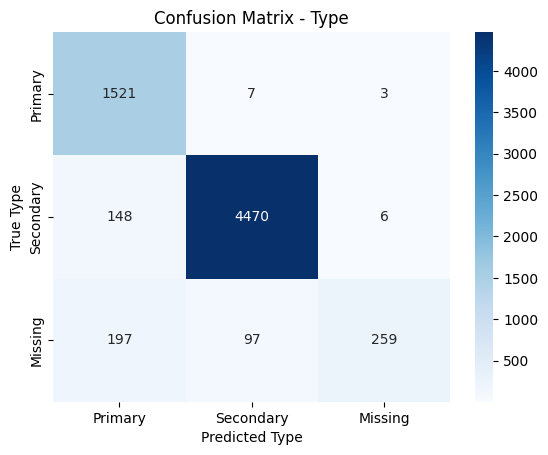

✅ Dataset ID Exact Match Accuracy: 0.0528


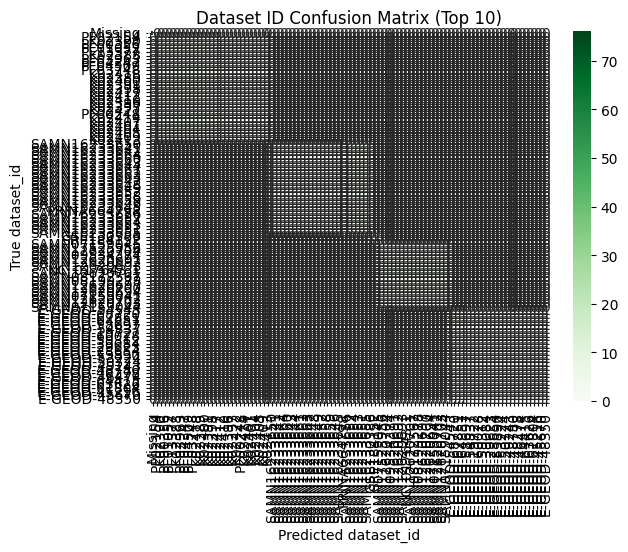

2470


In [26]:
DO_SAVE = False
import pandas as pd
if not SUBMIT:
    if DO_SAVE:
        df_true = pd.read_csv("/kaggle/input/make-data-count-finding-data-references/train_labels.csv")
        # Merge on article_id
        df_merged = df_true.merge(df_preds, on="article_id", suffixes=("_true", "_pred"))
        print(f"Merged {len(df_merged)} records.")
        df_merged.head()
        df_merged.to_csv("merged.csv", index=False)
    else:
        df_merged=pd.read_csv("/kaggle/input/mdc-submit-merged-ds/merged.csv")
    # df_merged['dataset_id_pred'] = df_merged['dataset_id_pred'].apply( lambda x: x.lower() if isinstance(x, str) and x.startswith('http') else x)
    from sklearn.metrics import classification_report, f1_score, confusion_matrix
    
    # Encode type as numeric labels
    type_label_map = {"Primary":0, "Secondary":1, "Missing":2}
    y_true_type = df_merged["type_true"].map(type_label_map)
    y_pred_type = df_merged["type_pred"].map(type_label_map)
    
    def compute_type_metrics(y_true, y_pred):
        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
        def safe_f1(class_label):
            return report[str(class_label)]["f1-score"] if str(class_label) in report else 0.0
    
        return {
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "f1_primary": safe_f1(0),
            "f1_secondary": safe_f1(1),
            "f1_missing": safe_f1(2)
        }
    
    type_metrics = compute_type_metrics(y_true_type, y_pred_type)
    print("✅ Type classification metrics")
    print(type_metrics)
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    cm = confusion_matrix(y_true_type, y_pred_type)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=type_label_map.keys(),
                yticklabels=type_label_map.keys())
    plt.xlabel("Predicted Type")
    plt.ylabel("True Type")
    plt.title("Confusion Matrix - Type")
    plt.show()
    
    df_merged = df_merged[df_merged['type_pred'] != 'Missing'].reset_index(drop=True)

    accuracy_ds = (df_merged["dataset_id_true"] == df_merged["dataset_id_pred"]).mean()
    print(f"✅ Dataset ID Exact Match Accuracy: {accuracy_ds:.4f}")
    
    top_n = 100
    counts = df_merged["dataset_id_true"].value_counts().nlargest(top_n)
    top_ids = counts.index.tolist()
    
    mask = df_merged["dataset_id_true"].isin(top_ids)
    cm_ds = confusion_matrix(
        df_merged.loc[mask, "dataset_id_true"],
        df_merged.loc[mask, "dataset_id_pred"],
        labels=top_ids
    )
    
    sns.heatmap(cm_ds, annot=True, fmt="d", cmap="Greens",
                xticklabels=top_ids,
                yticklabels=top_ids)
    plt.xlabel("Predicted dataset_id")
    plt.ylabel("True dataset_id")
    plt.title("Dataset ID Confusion Matrix (Top 10)")
    plt.show()
    print(cm_ds.sum())